In [2]:
import pandas as pd
from unipath import Path
import os
from datetime import datetime as dt
import pickle
import numpy as np
import time as time
import matplotlib.pyplot as plt
import sys

Import data

In [11]:
dirname = os.path.abspath(os.getcwd())
dirname = Path(dirname).resolve()
parentFolder = dirname.parent
parent2Folder = parentFolder.parent
filepath = os.path.join(parent2Folder,"Data","PJM\\",)
filename = filepath+'PJM_RTO_FuelTypeGen_16-18_Hourly.csv' 
Gen3Y = pd.read_csv(filename)
Gen3Y.columns = ["Date","Fuel","MW","Perc","IsRenew"]
Start = Gen3Y.shape[0]
Gen3Y = Gen3Y.drop_duplicates(["Date","Fuel"])
End = Gen3Y.shape[0]
print(str(Start-End) + " ""{0:.11%}".format((Start-End)/Start))

23 0.00798278495%


Clean into table with all columns and useful date properties

In [12]:
GenShort = Gen3Y.copy()
#GenShort["Values"] = list(zip(GenShort.MW, GenShort.Perc))
#GenShort = GenShort.pivot(index="Date",columns="Fuel", values=['Values'])
GenShort = GenShort.drop(["Perc","IsRenew"],axis=1)
GenShort = GenShort.pivot(index="Date", columns="Fuel", values='MW')

In [13]:
GenShort.insert(loc=0,column="Year",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').year)
GenShort.insert(loc=1,column="Month",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').month)
GenShort.insert(loc=2,column="Day",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').day)
GenShort.insert(loc=3,column="Hour",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').hour)
# GenShort['Month'] = pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').month
# GenShort['Day'] = pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').day
# GenShort['Hour'] = pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%Y %H:%M').hour
GenShort = GenShort.reset_index(drop=True)
GenShort = GenShort.drop("Flywheel",axis=1)
GenShort["SolWind"] = GenShort.iloc[:,[12,14]].sum(axis=1)
GenShort["RenewInclHyd"] = GenShort.iloc[:,[6,11,12,14]].sum(axis=1)
GenShort["RenewExclHyd"] = GenShort.iloc[:,[11,12,14]].sum(axis=1)
GenShort["Total"] = GenShort.iloc[:,range(4,15)].sum(axis=1)
GenShort.sort_values(["Year","Month","Day","Hour"], inplace=True, ascending=True)  
GenShort = GenShort.reset_index(drop=True)

In [5]:
#pickle.dump(GenShort, open( "GenShort.p", "wb" ))

In [5]:
GenShort = pickle.load(open("GenShort.p",'rb'))

Create a graph to visualize Renewable Production

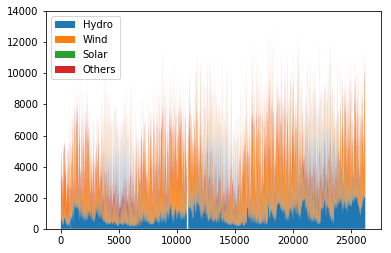

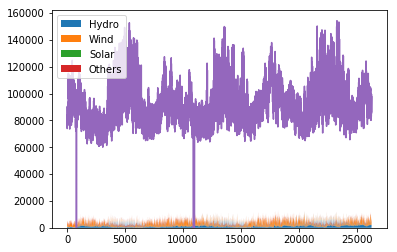

In [14]:
x = GenShort.index
p1 = GenShort["Hydro"]
p2 = GenShort["Wind"]
p3 = GenShort["Solar"]
p4 = GenShort["Other Renewables"]
y = np.vstack([p1,p2,p3,p4])
labels = ["Hydro","Wind","Solar","Others"]
fig, ax = plt.subplots()
ax.stackplot(x,p1,p2,p3,p4,labels=labels)
ax.legend(loc='upper left')
#plt.savefig('Renewable Production.png',dpi=300)
plt.show()

fig, ax = plt.subplots()
labels = ["Hydro","Wind","Solar","Others"]
ax.stackplot(x,p1,p2,p3,p4,labels=labels)
ax.legend(loc='upper left')
ax.plot(GenShort["Total"])
#plt.savefig('Total+Renewable.png',dpi=300)
plt.show()

Create Capacity Utilization

In [15]:
def calc_Util(columnRange,periods):
    
    start_time = time.time()
    columnRange = pd.DataFrame(columnRange)
    numRows = columnRange.shape[0]
    numCols  = columnRange.shape[1]
    outputRange = pd.DataFrame(np.zeros(shape=(columnRange.shape)),columns=columnRange.columns)
    
    for c in range(numCols):
        print(str(c) + "--- %s seconds ---" % (time.time() - start_time))
        
        maxColumn = columnRange.iloc[:,c].rolling(window=periods, center=True).max().fillna(method='bfill').fillna(method='pad')
        for r in range(numRows):
            if maxColumn[r]>0:               
                outputRange.iloc[r,c] = columnRange.iloc[r,c]/maxColumn[r]
            else:
                outputRange.iloc[r,c] = 0 #To avoid division by zero
                
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return outputRange

In [16]:
GenPerc = GenShort.copy() #Following calculations take about 20 minutes
GenPerc.iloc[:,range(4,18)] = calc_Util(GenShort.iloc[:,range(4,18)],360*24)#All production methods are run with 1/2 year both ways
GenPerc.iloc[:,range(18,19)] = calc_Util(GenShort.iloc[:,range(18,19)],(30*24))#.values

0--- 0.0 seconds ---
1--- 3.7983100414276123 seconds ---
2--- 7.657379627227783 seconds ---
3--- 11.484599590301514 seconds ---
4--- 15.469377517700195 seconds ---
5--- 19.468404054641724 seconds ---
6--- 23.42223334312439 seconds ---
7--- 27.25102972984314 seconds ---
8--- 31.187599420547485 seconds ---
9--- 35.186625957489014 seconds ---
10--- 38.78183650970459 seconds ---
11--- 42.734028816223145 seconds ---
12--- 46.63938307762146 seconds ---
13--- 50.60875678062439 seconds ---
--- 54.45147085189819 seconds ---
0--- 0.0 seconds ---
--- 3.889737606048584 seconds ---


In [85]:
#pickle.dump(GenPerc, open( "GenPerc.p", "wb" ))

In [ ]:
#GenPerc = pickle.load(open("GenPerc.p",'rb'))

Create average Utlization

In [ ]:
start_time = time.time() #Takes about 12 minutes to run
GenAvg = GenPerc.drop_duplicates(["Month","Day","Hour"])
for r in range(GenAvg.shape[0]):
    if r%1000 == 0:
        print(str(r) + "--- %s seconds ---" % (time.time() - start_time))
    DummyArray = GenPerc[GenPerc.Day==GenAvg.iloc[r,2]]
    DummyArray = DummyArray[GenPerc.Hour==GenAvg.iloc[r,3]]
    DummyArray = DummyArray[GenPerc.Month==GenAvg.iloc[r,1]]
    GenAvg.iloc[r,:] = DummyArray.mean() 

GenAvg = GenAvg.drop("Year",axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

In [88]:
#pickle.dump(GenAvg, open( "GenAvg.p", "wb" ))

In [3]:
GenAvg = pickle.load(open("GenAvg.p",'rb'))

Now, go and simulate - proliferate and be happy

In [4]:
PeakLimit = 2/3
QueueData = GenAvg.drop(GenAvg.columns[range(0,14)],axis=1)
peakTH = QueueData.Total.quantile(PeakLimit)
renewAvg = [QueueData.SolWind.mean(),QueueData.RenewInclHyd.mean(),QueueData.RenewExclHyd.mean()]
#Create demand rates that are dependent on it being a peak hour or not and average Sup Rate
QueueData["SolWindRate"] = (QueueData.SolWind/renewAvg[0])
QueueData["RenewInclRate"] = (QueueData.RenewInclHyd/renewAvg[1])
QueueData["RenewExclRate"] = (QueueData.RenewExclHyd/renewAvg[2])
QueueData["DemRate"] = (QueueData.Total>=peakTH)*(1/(1-PeakLimit))#Rescale demand during peak time to average 1 unit acros alL periods

Function to create Rate Matrix of M/M/1 queue given rates and state space

In [5]:
#Function to create RateMatrix
def create_RateMatrix(lamb,mu,States):
    if States == 1:
        return np.eye(1)
    
    RateMatrix = np.eye(States)
    RateMatrix.ravel()[1:max(0,States-1)*States:States+1] = lamb
    RateMatrix.ravel()[States*1:States*(1+States):States+1] = mu
    np.fill_diagonal(RateMatrix,(-(lamb+mu)))
    RateMatrix[0,0]=-lamb
    RateMatrix[(States-1),(States-1)]=-mu
    
    return RateMatrix

In [6]:
def NHPP_Simul(BatterySize, intervalsPerHour, lambArr, muArr, approxIter):
    
    #Error Checking at its best
    try:
        if type(BatterySize) != int:
            return print("The BatterySize has to be an integer")
    except:
        return print("Provided the wrong data formate for the Battery Size. Please pass an integer to the function")

    try:
        if  type(intervalsPerHour) != int:
            return print("The intervals per hour have to be an integer")    
    except:
        return print("Provided the wrong data formate for the intervals. Please pass an integer to the function")
    
    try:
        if len(lambArr) != len(muArr):
            return print("Supply and Demand rate are not of identical length")
    except:
        return print("Provided the wrong data format for the Rates. Please pass columns to the function")
    
    try:
        if  type(approxIter) != int:
            return print("Num of iterations for rate approximation have to be integer values")
    except:
        return print("Provided the wrong data format for the approximation runs. Please pass an integer to the function")
    
    
    #Adjust for the subperiod lengths
    BatterySize += 1 #Battery state spaces are one larger than the battery
    periods = len(lambArr)-1
    subperiods = periods*intervalsPerHour
    
    #Create all arrays needed during calculation
    loss = np.zeros(shape=(1,BatterySize))
    I = np.eye(BatterySize)
    Pis = np.zeros(BatterySize)
    Pis[BatterySize-1] = 1 
    PiZeros = np.zeros(subperiods+1)
    PiZeros[0] = 0

    #Calculate All Transition Rates
    for subperiod in range(subperiods):
        hour = int(subperiod/intervalsPerHour)
            
        #Check if you need new ratematrix
        if subperiod%intervalsPerHour==0:
            RateMatrix = create_RateMatrix(lambArr[hour],muArr[hour],BatterySize)
            TransPr = np.linalg.matrix_power(I + 0.5*RateMatrix/intervalsPerHour/approxIter,approxIter)#Continuity Correction
        
        #Multiply new probabilities
        Pis = np.dot(Pis,TransPr)
 
        #Paste loss value
        PiZeros[subperiod+1] = Pis[0]
        
        #Calculate second half of period
        Pis = np.dot(Pis,TransPr)

        
    return PiZeros, PiZeros.mean()

Cycle through different sizes of battery and find percentage at which battery is empty

In [7]:
UpperLimit = 5*24
NumYears = 10
BatAt0Avg = np.zeros(shape=(UpperLimit,3))
#Simulates this stuff, but for 10 years. #10 Years for 48 Battery Capacity takes about 
start_time = time.time()
for SizeRun in range(0,UpperLimit):
    if SizeRun%10 == 0:
        print(str(SizeRun) + "--- %s seconds ---" % (time.time() - start_time))
    #Run it with Num Years * Observations, iterate over all battery sizes with 10 subperiods per period...
    _ , BatAt0Avg[SizeRun,0] = NHPP_Simul(SizeRun,10,np.tile(QueueData.SolWindRate,NumYears),np.tile(QueueData.DemRate,NumYears),1024)
    _ , BatAt0Avg[SizeRun,1] = NHPP_Simul(SizeRun,10,np.tile(QueueData.RenewInclRate,NumYears),np.tile(QueueData.DemRate,NumYears),1024)
    _ , BatAt0Avg[SizeRun,2] = NHPP_Simul(SizeRun,10,np.tile(QueueData.RenewExclRate,NumYears),np.tile(QueueData.DemRate,NumYears),1024)



0--- 0.0 seconds ---


C:\Users\ckaps\AppData\Local\conda\conda\envs\BatteryEnv\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


10--- 124.89778804779053 seconds ---
20--- 265.23899030685425 seconds ---
30--- 447.0811448097229 seconds ---
40--- 694.9748537540436 seconds ---
50--- 1041.5476169586182 seconds ---
60--- 1540.794988155365 seconds ---
70--- 2486.2467119693756 seconds ---


KeyboardInterrupt: 

In [ ]:
pickle.dump(BatAt0Avg, open( "BatAt0Avg120.p", "wb" ))

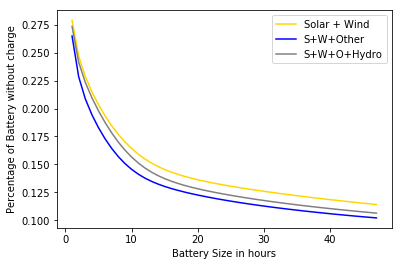

In [17]:
#Plot BatterySize vs outage over time 
x = [*range(0,len(BatAt0Avg))]
y0 = BatAt0Avg[:,0]
y1 = BatAt0Avg[:,1]
y2 = BatAt0Avg[:,2]
y3 = BatAt0Avg[:,2]

plt.plot(x,y0, color='Gold')
plt.plot(x,y1, color='Blue')
plt.plot(x,y2, color='Grey')

plt.xlabel("Battery Size in hours")
plt.ylabel("Percentage of Battery without charge")
plt.legend(["Solar + Wind","S+W+Other","S+W+O+Hydro"])
plt.savefig("BatteryCurve120.png",dpi=300)
plt.show()